# Machine Learning Trading Bot

## Background
- Three machine learning models were utilized to train and predict the trading data sourced from Alpaca API. 
- The target was determined to be the entry price plus 3 times the Average True Range(ATR): '1'.
- The stop was determined to be the entry price minus the Average True Range (ATR): '-1'. 
- Support Vector Machine (SVM), Decision Tree models, and Stochasstic Gradient Descent (SGD) were applied to this data.

In [1]:
# initial imports
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt 
from finta import TA

import pandas as pd 
import hvplot.pandas
from pandas.tseries.offsets import DateOffset

import alpaca_trade_api as tradeapi

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm

from imblearn.under_sampling import RandomUnderSampler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import alpaca
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
from dateutil.relativedelta import relativedelta

ticker = "ETH/USD"
time_diff = datetime.now() - relativedelta(days=30)

# Alpaca Market Data Client
data_client = CryptoHistoricalDataClient()

# Defining Bar data request parameters
request_params = CryptoBarsRequest(
    symbol_or_symbols=[ticker],
    timeframe=TimeFrame(5, alpaca.data.timeframe.TimeFrameUnit.Minute),
    start=time_diff
)

# Get the bar data from Alpaca
signals_df = data_client.get_crypto_bars(request_params).df

signals_df.reset_index(level='symbol', inplace=True)
signals_df.drop(columns=["symbol"], inplace=True)

signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2023-08-21 21:40:00+00:00,1674.4900,1675.0825,1673.0975,1673.0975,0.056456,2.0,1674.289991
2023-08-21 21:45:00+00:00,1673.5665,1673.9285,1672.1000,1672.2000,0.000000,0.0,0.000000
2023-08-21 21:50:00+00:00,1672.6000,1673.1750,1672.1205,1672.4200,0.000000,0.0,0.000000
2023-08-21 21:55:00+00:00,1672.5900,1673.8500,1672.3455,1673.0300,0.000000,0.0,0.000000
2023-08-21 22:00:00+00:00,1673.1700,1673.4500,1671.3300,1672.1000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
2023-09-21 02:15:00+00:00,1621.2525,1621.2525,1619.1530,1619.1530,0.000000,0.0,0.000000
2023-09-21 02:20:00+00:00,1618.7000,1618.8500,1615.9195,1615.9195,0.000000,0.0,0.000000
2023-09-21 02:25:00+00:00,1616.7535,1617.3000,1616.2530,1617.0150,0.001400,1.0,1616.253000


In [3]:
# # save copy
# signals_df.to_csv("./ETH_time_series.csv", index="timestamp")

# signals_df

### Download stock time-series data from Alpaca API into Pandas DataFrame

In [4]:
# # THE FOLLOWING IS TO REQUEST IN DATA USING THE ALPACA_API
# # API credentials
# API_KEY = 'PKD98H4EZF8YRDLUZ5I2'
# SECRET_KEY = 'b5ZbNnx35m3uaB6vRnrU7TLQlgEfDw0bKf1Y8Zsm'
# API_BASE_URL = "https://paper-api.alpaca.markets"

# # Create a connection to the API 
# api = tradeapi.REST(API_KEY, SECRET_KEY, API_BASE_URL, api_version="v2")
    
# # Set the ticket symbol and the number of shares to buy
# ticker = "SPY"

# # Make API call
# signals_df = api.get_bars(ticker, "5min", start="2023-09-20").df

# # # Save the DataFrame with the date index
# # signals_df.to_csv('SPY_15min_time_series_df.csv')

# # create a seperate dataframe for signals
# signals_df

In [5]:
# # stock_data.py

# import alpaca
# from alpaca.data.historical import StockHistoricalDataClient
# from alpaca.data.requests import StockBarsRequest
# from alpaca.data.timeframe import TimeFrame
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# APCA_API_KEY_ID = 'PKD98H4EZF8YRDLUZ5I2'
# APCA_API_SECRET_KEY = 'b5ZbNnx35m3uaB6vRnrU7TLQlgEfDw0bKf1Y8Zsm'
# ticker = "SPY"
# timeDiff = datetime.now() - relativedelta(days=1)
# # keys required for stock historical data client
# client = StockHistoricalDataClient(APCA_API_KEY_ID, APCA_API_SECRET_KEY)

# # multi symbol request - single symbol is similar
# multisymbol_request_params = StockBarsRequest(
#     symbol_or_symbols=[ticker],
#     timeframe=TimeFrame(15, alpaca.data.timeframe.TimeFrameUnit.Minute),
#     start=timeDiff)

# latest_multisymbol_quotes = client.get_stock_bars(multisymbol_request_params).df
# latest_multisymbol_quotes

# # signals_df.drop(columns=["symbol"], inplace=True)

# # signals_df

In [6]:
# # stock_data.py

# import alpaca
# from alpaca.data.historical import StockHistoricalDataClient
# from alpaca.data.requests import StockLatestBarRequest
# from alpaca.data.timeframe import TimeFrame
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# APCA_API_KEY_ID = 'PKD98H4EZF8YRDLUZ5I2'
# APCA_API_SECRET_KEY = 'b5ZbNnx35m3uaB6vRnrU7TLQlgEfDw0bKf1Y8Zsm'
# ticker = "SPY"
# timeDiff = datetime.now() - relativedelta(days=1)
# # keys required for stock historical data client
# client = StockHistoricalDataClient(APCA_API_KEY_ID, APCA_API_SECRET_KEY)

# # multi symbol request - single symbol is similar
# multisymbol_request_params = StockLatestBarRequest(
#     symbol_or_symbols=[ticker],
#     timeframe=TimeFrame(5, alpaca.data.timeframe.TimeFrameUnit.Minute),
#     start=timeDiff)

# latest_multisymbol_quotes = client.get_stock_latest_bar(multisymbol_request_params)
# latest_multisymbol_quotes

# # signals_df.drop(columns=["symbol"], inplace=True)

# # signals_df

In [7]:
StockBarsRequest?

Object `StockBarsRequest` not found.


In [8]:
api.get_bars?

Object `api.get_bars` not found.


In [9]:
type(signals_df.index[0])

pandas._libs.tslibs.timestamps.Timestamp

### Read in stock time-series data from .csv file into Pandas DataFrame

In [10]:
# # Set ticker
# ticker = "AAPL"

# # Load the DataFrame from a CSV file
# signals_df = pd.read_csv('AAPL_time_series_df.csv', index_col="timestamp")

# # Convert the first column (assuming it contains datetime-like values) to DatetimeIndex
# signals_df.index = pd.to_datetime(signals_df.index)

# # Define NYSE regular trading hours
# nyse_opening_time = pd.Timestamp("09:30:00")
# nyse_closing_time = pd.Timestamp("16:00:00")

# # Filter the DataFrame to include only data within NYSE regular trading hours
# signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# # save copy
# signals_df.to_csv("../data/SPY_time_series.csv", index="timestamp")

signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2023-08-21 21:40:00+00:00,1674.4900,1675.0825,1673.0975,1673.0975,0.056456,2.0,1674.289991
2023-08-21 21:45:00+00:00,1673.5665,1673.9285,1672.1000,1672.2000,0.000000,0.0,0.000000
2023-08-21 21:50:00+00:00,1672.6000,1673.1750,1672.1205,1672.4200,0.000000,0.0,0.000000
2023-08-21 21:55:00+00:00,1672.5900,1673.8500,1672.3455,1673.0300,0.000000,0.0,0.000000
2023-08-21 22:00:00+00:00,1673.1700,1673.4500,1671.3300,1672.1000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
2023-09-21 02:15:00+00:00,1621.2525,1621.2525,1619.1530,1619.1530,0.000000,0.0,0.000000
2023-09-21 02:20:00+00:00,1618.7000,1618.8500,1615.9195,1615.9195,0.000000,0.0,0.000000
2023-09-21 02:25:00+00:00,1616.7535,1617.3000,1616.2530,1617.0150,0.001400,1.0,1616.253000


<Axes: title={'center': 'ETH/USD Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

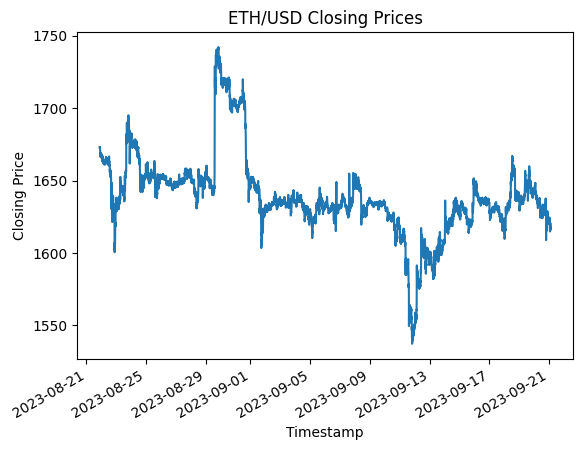

In [11]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

### Add Features (Techincal Analysis Indicators) to the DataFrame

In [12]:
# continuous features (techinal indicators) may be used
features = ["open", "high", "low", "close", "volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_MIDDLE", "BB_LOWER", "MACD"]

#  Setup EMAs for crosses
longest_MA_window = 200
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, longest_MA_window)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns=["SIGNAL"], inplace=True)

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Entry Price"] = 0
signals_df["Entry Time"] = 0

signals_df["Exit Price"] = 0
signals_df["Exit Time"] = 0
signals_df["Exit"] = 0

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-21 21:40:00+00:00,1674.4900,1675.0825,1673.0975,1673.0975,0.056456,2.0,1674.289991,1673.097500,1673.097500,1673.097500,...,NaN,NaN,NaN,NaN,0.000000,0,0,0,0,0
2023-08-21 21:45:00+00:00,1673.5665,1673.9285,1672.1000,1672.2000,0.000000,0.0,0.000000,1672.598889,1672.626313,1672.639775,...,0.000000,NaN,NaN,NaN,-0.020136,0,0,0,0,0
2023-08-21 21:50:00+00:00,1672.6000,1673.1750,1672.1205,1672.4200,0.000000,0.0,0.000000,1672.525574,1672.550556,1672.563567,...,20.884896,NaN,NaN,NaN,-0.018835,0,0,0,0,0
2023-08-21 21:55:00+00:00,1672.5900,1673.8500,1672.3455,1673.0300,0.000000,0.0,0.000000,1672.696450,1672.688964,1672.687263,...,51.272578,NaN,NaN,NaN,0.004242,0,0,0,0,0
2023-08-21 22:00:00+00:00,1673.1700,1673.4500,1671.3300,1672.1000,0.000000,0.0,0.000000,1672.519020,1672.546499,1672.560230,...,31.443379,NaN,NaN,NaN,-0.020315,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-21 02:15:00+00:00,1621.2525,1621.2525,1619.1530,1619.1530,0.000000,0.0,0.000000,1618.706052,1618.886397,1620.483043,...,49.442576,1623.660583,1618.563525,1613.466467,-0.621581,0,0,0,0,0
2023-09-21 02:20:00+00:00,1618.7000,1618.8500,1615.9195,1615.9195,0.000000,0.0,0.000000,1618.148742,1618.603836,1620.304080,...,39.144121,1623.153838,1618.244900,1613.335962,-0.790165,0,0,0,0,0
2023-09-21 02:25:00+00:00,1616.7535,1617.3000,1616.2530,1617.0150,0.001400,1.0,1616.253000,1617.921993,1618.452518,1620.175097,...,43.442322,1621.825018,1617.871400,1613.917782,-0.825852,0,0,0,0,0


In [13]:
# Define NYSE regular trading hours
nyse_opening_time = pd.Timestamp("09:30:00")
nyse_closing_time = pd.Timestamp("16:00:00")

# Filter the DataFrame to include only data within NYSE regular trading hours
signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# Review DataFrame
signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-22 09:30:00+00:00,1663.7820,1664.1100,1662.3725,1662.6125,0.000000,0.0,0.0,1663.956966,1664.256438,1664.146023,...,38.815652,1666.449397,1664.615650,1662.781903,-0.170149,0,0,0,0,0
2023-08-22 09:35:00+00:00,1663.1500,1664.3600,1663.1500,1664.0785,0.000000,0.0,0.0,1663.981273,1664.239491,1664.143366,...,48.965152,1666.248215,1664.520025,1662.791835,-0.158810,0,0,0,0,0
2023-08-22 09:40:00+00:00,1664.3375,1665.3400,1663.6455,1665.3400,0.000000,0.0,0.0,1664.253018,1664.344302,1664.190436,...,55.765123,1666.052310,1664.474525,1662.896740,-0.047485,0,0,0,0,0
2023-08-22 09:45:00+00:00,1667.4260,1667.4260,1665.5650,1665.5650,0.000000,0.0,0.0,1664.515414,1664.460559,1664.244497,...,56.868973,1665.970331,1664.456275,1662.942219,0.058225,0,0,0,0,0
2023-08-22 09:50:00+00:00,1665.8625,1666.4500,1664.8330,1664.9020,0.000000,0.0,0.0,1664.592732,1664.502601,1664.270354,...,52.696063,1665.768256,1664.404425,1663.040594,0.087494,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20 15:40:00+00:00,1626.9285,1628.8605,1626.9285,1628.8605,0.000000,0.0,0.0,1627.896440,1628.305480,1628.856934,...,51.212662,1632.214715,1628.665225,1625.115735,-0.360585,0,0,0,0,0
2023-09-20 15:45:00+00:00,1629.1500,1630.9555,1629.1500,1630.0070,0.000607,1.0,1630.9,1628.318552,1628.467530,1628.902034,...,54.136830,1631.574600,1628.525575,1625.476550,-0.177672,0,0,0,0,0
2023-09-20 15:50:00+00:00,1630.2700,1630.2700,1629.2400,1629.4950,0.000000,0.0,0.0,1628.553841,1628.565384,1628.925288,...,52.620035,1631.650839,1628.571075,1625.491311,-0.073182,0,0,0,0,0


In [14]:
# Disable the warning
pd.options.mode.chained_assignment = None  # "None" suppresses the warning

### Create Volatility Based Targets and Stops

In [15]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
num_rows_in_df = signals_df.shape[0]

# reward:risk ratio
reward = 5
risk = 5

# we also figure out our exit price
# hitting target price before the stop price signals a win and will be 1
# hitting stop price before hitting the target price signals a loss and will be -1
# loop thru the dataframe, from the longest_MA_window to the end (num_rows_in_df) to avoid NaN values
for j in range(longest_MA_window, num_rows_in_df):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    signals_df["Entry Price"].iloc[j] = entry
    signals_df["Entry Time"].iloc[j] = signals_df.index[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - (risk * atr)
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (reward * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, num_rows_in_df):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df["Exit Price"].iloc[j] = stop
            signals_df["Exit"].iloc[j] = -1
            # record exit time
            signals_df["Exit Time"].iloc[j] = signals_df.index[k] 
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df["Exit Price"].iloc[j] = target
            signals_df["Exit"].iloc[j] = 1
            # record exit time
            signals_df["Exit Time"].iloc[j] = signals_df.index[k] 
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[longest_MA_window:]

signals_df

C:\Users\range\AppData\Local\Temp\ipykernel_27956\3559175957.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1667.435' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df["Entry Price"].iloc[j] = entry
C:\Users\range\AppData\Local\Temp\ipykernel_27956\3559175957.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2023-08-24 13:00:00+00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df["Entry Time"].iloc[j] = signals_df.index[j]
C:\Users\range\AppData\Local\Temp\ipykernel_27956\3559175957.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1658.263035714286' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df["Exit Price

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-24 13:00:00+00:00,1666.7800,1668.1200,1666.7800,1667.4350,0.000599,1.0,1668.12,1667.489201,1668.055185,1669.455160,...,45.438441,1673.117982,1668.339775,1663.561568,-0.724603,1667.4350,2023-08-24 13:00:00+00:00,1658.263036,2023-08-24 14:15:00+00:00,-1
2023-08-24 13:05:00+00:00,1666.9500,1667.8800,1666.9500,1667.4500,0.000000,0.0,0.00,1667.481361,1667.997548,1669.376526,...,45.515422,1672.592855,1668.115075,1663.637295,-0.685318,1667.4500,2023-08-24 13:05:00+00:00,1658.669286,2023-08-24 14:15:00+00:00,-1
2023-08-24 13:10:00+00:00,1666.5015,1666.5015,1664.9350,1665.9050,0.000000,0.0,0.00,1667.166089,1667.798258,1669.240388,...,39.356177,1671.712036,1667.762075,1663.812114,-0.769977,1665.9050,2023-08-24 13:10:00+00:00,1656.768393,2023-08-24 14:20:00+00:00,-1
2023-08-24 13:15:00+00:00,1665.1895,1666.1100,1664.9350,1664.9840,0.527619,1.0,1666.11,1666.729671,1667.530233,1669.073471,...,36.210466,1670.838658,1667.386525,1663.934392,-0.901001,1664.9840,2023-08-24 13:15:00+00:00,1655.953107,2023-08-24 14:25:00+00:00,-1
2023-08-24 13:20:00+00:00,1664.9175,1664.9400,1663.0650,1663.3295,0.000000,0.0,0.00,1666.049637,1667.130163,1668.848217,...,31.361060,1670.386463,1666.989400,1663.592337,-1.125370,1663.3295,2023-08-24 13:20:00+00:00,1654.192714,2023-08-24 14:25:00+00:00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20 15:40:00+00:00,1626.9285,1628.8605,1626.9285,1628.8605,0.000000,0.0,0.00,1627.896440,1628.305480,1628.856934,...,51.212662,1632.214715,1628.665225,1625.115735,-0.360585,1628.8605,2023-09-20 15:40:00+00:00,0.000000,0,0
2023-09-20 15:45:00+00:00,1629.1500,1630.9555,1629.1500,1630.0070,0.000607,1.0,1630.90,1628.318552,1628.467530,1628.902034,...,54.136830,1631.574600,1628.525575,1625.476550,-0.177672,1630.0070,2023-09-20 15:45:00+00:00,0.000000,0,0
2023-09-20 15:50:00+00:00,1630.2700,1630.2700,1629.2400,1629.4950,0.000000,0.0,0.00,1628.553841,1628.565384,1628.925288,...,52.620035,1631.650839,1628.571075,1625.491311,-0.073182,1629.4950,2023-09-20 15:50:00+00:00,0.000000,0,0


### Data Cleaning

In [16]:
# include only rows with an exit time
signals_df = signals_df.loc[signals_df["Exit Time"] != 0]

# remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]

# # include only higher than 1 volume
# signals_df = signals_df.loc[signals_df["volume"] != 0]

signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-24 13:00:00+00:00,1666.7800,1668.1200,1666.7800,1667.4350,0.000599,1.0,1668.120,1667.489201,1668.055185,1669.455160,...,45.438441,1673.117982,1668.339775,1663.561568,-0.724603,1667.4350,2023-08-24 13:00:00+00:00,1658.263036,2023-08-24 14:15:00+00:00,-1
2023-08-24 13:05:00+00:00,1666.9500,1667.8800,1666.9500,1667.4500,0.000000,0.0,0.000,1667.481361,1667.997548,1669.376526,...,45.515422,1672.592855,1668.115075,1663.637295,-0.685318,1667.4500,2023-08-24 13:05:00+00:00,1658.669286,2023-08-24 14:15:00+00:00,-1
2023-08-24 13:10:00+00:00,1666.5015,1666.5015,1664.9350,1665.9050,0.000000,0.0,0.000,1667.166089,1667.798258,1669.240388,...,39.356177,1671.712036,1667.762075,1663.812114,-0.769977,1665.9050,2023-08-24 13:10:00+00:00,1656.768393,2023-08-24 14:20:00+00:00,-1
2023-08-24 13:15:00+00:00,1665.1895,1666.1100,1664.9350,1664.9840,0.527619,1.0,1666.110,1666.729671,1667.530233,1669.073471,...,36.210466,1670.838658,1667.386525,1663.934392,-0.901001,1664.9840,2023-08-24 13:15:00+00:00,1655.953107,2023-08-24 14:25:00+00:00,-1
2023-08-24 13:20:00+00:00,1664.9175,1664.9400,1663.0650,1663.3295,0.000000,0.0,0.000,1666.049637,1667.130163,1668.848217,...,31.361060,1670.386463,1666.989400,1663.592337,-1.125370,1663.3295,2023-08-24 13:20:00+00:00,1654.192714,2023-08-24 14:25:00+00:00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20 12:20:00+00:00,1631.2500,1631.2500,1629.2745,1629.2745,0.000000,0.0,0.000,1630.042141,1629.917913,1630.952357,...,45.938676,1631.563788,1629.917125,1628.270462,-0.007314,1629.2745,2023-09-20 12:20:00+00:00,1621.930214,2023-09-20 13:25:00+00:00,-1
2023-09-20 12:35:00+00:00,1626.6600,1627.0000,1624.7140,1624.7140,0.000000,0.0,0.000,1628.330216,1629.079535,1630.478147,...,29.706964,1632.600934,1629.661650,1626.722366,-0.666400,1624.7140,2023-09-20 12:35:00+00:00,1633.587393,2023-09-20 14:00:00+00:00,1
2023-09-20 12:40:00+00:00,1624.3620,1625.3820,1624.1030,1624.7185,0.000000,0.0,0.000,1627.607873,1628.664198,1630.252278,...,29.734545,1633.120302,1629.445075,1625.769848,-0.931306,1624.7185,2023-09-20 12:40:00+00:00,1633.060643,2023-09-20 13:50:00+00:00,1


<Axes: title={'center': 'ETH/USD Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

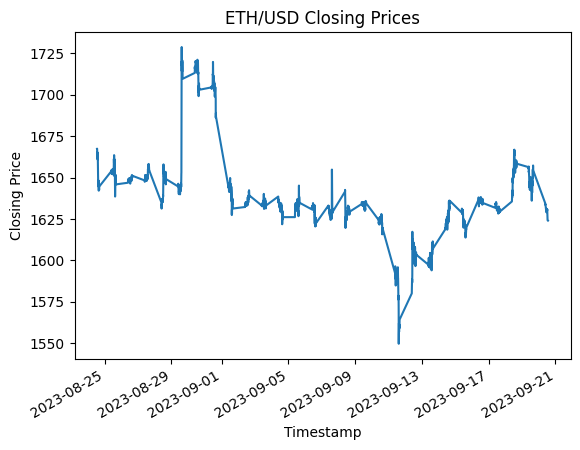

In [17]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

In [18]:
# make sure we have a sufficient training period
training_begin = str(signals_df.index.min())
training_end = str(signals_df.index.min() + DateOffset(months=2))

signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,...,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Entry Price,Entry Time,Exit Price,Exit Time,Exit
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-08-24 13:00:00+00:00,1666.7800,1668.1200,1666.7800,1667.4350,0.000599,1.0,1668.120,1667.489201,1668.055185,1669.455160,...,45.438441,1673.117982,1668.339775,1663.561568,-0.724603,1667.4350,2023-08-24 13:00:00+00:00,1658.263036,2023-08-24 14:15:00+00:00,-1
2023-08-24 13:05:00+00:00,1666.9500,1667.8800,1666.9500,1667.4500,0.000000,0.0,0.000,1667.481361,1667.997548,1669.376526,...,45.515422,1672.592855,1668.115075,1663.637295,-0.685318,1667.4500,2023-08-24 13:05:00+00:00,1658.669286,2023-08-24 14:15:00+00:00,-1
2023-08-24 13:10:00+00:00,1666.5015,1666.5015,1664.9350,1665.9050,0.000000,0.0,0.000,1667.166089,1667.798258,1669.240388,...,39.356177,1671.712036,1667.762075,1663.812114,-0.769977,1665.9050,2023-08-24 13:10:00+00:00,1656.768393,2023-08-24 14:20:00+00:00,-1
2023-08-24 13:15:00+00:00,1665.1895,1666.1100,1664.9350,1664.9840,0.527619,1.0,1666.110,1666.729671,1667.530233,1669.073471,...,36.210466,1670.838658,1667.386525,1663.934392,-0.901001,1664.9840,2023-08-24 13:15:00+00:00,1655.953107,2023-08-24 14:25:00+00:00,-1
2023-08-24 13:20:00+00:00,1664.9175,1664.9400,1663.0650,1663.3295,0.000000,0.0,0.000,1666.049637,1667.130163,1668.848217,...,31.361060,1670.386463,1666.989400,1663.592337,-1.125370,1663.3295,2023-08-24 13:20:00+00:00,1654.192714,2023-08-24 14:25:00+00:00,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20 12:20:00+00:00,1631.2500,1631.2500,1629.2745,1629.2745,0.000000,0.0,0.000,1630.042141,1629.917913,1630.952357,...,45.938676,1631.563788,1629.917125,1628.270462,-0.007314,1629.2745,2023-09-20 12:20:00+00:00,1621.930214,2023-09-20 13:25:00+00:00,-1
2023-09-20 12:35:00+00:00,1626.6600,1627.0000,1624.7140,1624.7140,0.000000,0.0,0.000,1628.330216,1629.079535,1630.478147,...,29.706964,1632.600934,1629.661650,1626.722366,-0.666400,1624.7140,2023-09-20 12:35:00+00:00,1633.587393,2023-09-20 14:00:00+00:00,1
2023-09-20 12:40:00+00:00,1624.3620,1625.3820,1624.1030,1624.7185,0.000000,0.0,0.000,1627.607873,1628.664198,1630.252278,...,29.734545,1633.120302,1629.445075,1625.769848,-0.931306,1624.7185,2023-09-20 12:40:00+00:00,1633.060643,2023-09-20 13:50:00+00:00,1


In [19]:
signals_df.to_csv("AAPL_time_series.csv", index_label="timestamp")

### Split the data into training and testing sets.

In [20]:
# choose features
X = signals_df[features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
y = signals_df["Exit"]
y.head()

timestamp
2023-08-24 13:00:00+00:00   -1
2023-08-24 13:05:00+00:00   -1
2023-08-24 13:10:00+00:00   -1
2023-08-24 13:15:00+00:00   -1
2023-08-24 13:20:00+00:00   -1
Name: Exit, dtype: int64

In [21]:
# Splitting into Train and Test sets
X_train = X.loc[training_begin: training_end]
y_train = y.loc[training_begin: training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [22]:
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

ValueError: Found array with 0 sample(s) (shape=(0, 17)) while a minimum of 1 is required by StandardScaler.

In [ ]:
# Undersample the data
rus = RandomUnderSampler(random_state=1)
undersampled_X_train_scaled, undersampled_y_train = rus.fit_resample(X_train_scaled, y_train)

### Support Vector Machine (SVC) Model

In [ ]:
# Create the classifier model
model = svm.SVC(probability=True, random_state=1)
 
# Fit the model to the data using undersampled_X_train_scaled and undersampled_y_train
model = model.fit(undersampled_X_train_scaled, undersampled_y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = model.predict(undersampled_X_train_scaled)
training_probability_estimates = model.predict_proba(undersampled_X_train_scaled)

In [ ]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'ETH_5MIN_10TO10_SVM.pkl')

In [ ]:
# Save the X_Scaler
joblib.dump(X_scaler, "X_scaler.save") 

In [ ]:
# Evaluate the model using a classification report
training_report = classification_report(undersampled_y_train, training_signal_predictions)
print(training_report)

In [ ]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)
testing_probability_estimates = model.predict_proba(X_test_scaled)

In [ ]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

### Visualization

In [ ]:
###########CHECK THIS!!!!!!#################
# Create a predictions DataFrame for SVM
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = signals_df["close"].pct_change()

#####################

predictions_df[["Entry Price", "Entry Time", "Exit Price", "Exit Time"]] = signals_df[["Entry Price", "Entry Time", "Exit Price", "Exit Time"]]

####################

predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["Entry Price"])/signals_df["Entry Price"]

predictions_df["trading_algorithm_returns"] = predictions_df.pop("algo_returns") * predictions_df["predicted_signal"]

predictions_df["probability_estimates"] = testing_probability_estimates[:, 1]

predictions_df.head(20)

In [ ]:
# Initialize buy_signals_df
buy_signals_df = pd.DataFrame()
buy_signals_df = pd.concat([buy_signals_df, predictions_df.iloc[[0]]])

# Loop to execute one buy trade at a time
# Initialize the last trade exit time with the first row's exit time
last_trade_exit_time = predictions_df["Exit Time"].iloc[0]

# Iterate through the DataFrame to find entry points for buy trades
for j in range(1, predictions_df.shape[0]):
    # Get the entry time and exit signal for the current row
    entry_time = predictions_df["Entry Time"].iloc[j]
    exit_signal = predictions_df["predicted_signal"].iloc[j]
    # Check if the current entry time is before or equal to the last trade's exit time
    # or if the exit signal is -1; if so, skip this iteration
    if entry_time <= last_trade_exit_time or exit_signal == -1:
        continue
    else:
        # Concatenate the current row to the buy_signals_df DataFrame
        buy_signals_df = pd.concat([buy_signals_df, predictions_df.iloc[[j]]])
        # Update the last trade exit time with the current row's exit time
        last_trade_exit_time = predictions_df["Exit Time"].iloc[j]

# # Filter rows where the predicted signal is 1 and the probability estimate is >= prob
buy_signals_df = buy_signals_df[(buy_signals_df["probability_estimates"] >= 0.50)]

buy_signals_df

In [ ]:
buy_signals_df.to_csv("AAPL_signals_df.csv", index_label="timestamp")

### Evaluation Metrics

In [ ]:
# Calculate the time period for which you want to calculate the frequency (e.g., in days)
start_date = buy_signals_df.index.min()
end_date = buy_signals_df.index.max()
time_period_days = (end_date - start_date).days + 1  # Adding 1 to include both start and end dates

# Filter the winning, losing, and total trades
winning_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]
losing_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]
total_trades = buy_signals_df["trading_algorithm_returns"]

# Calculate gross profit (positive returns) and gross loss (negative returns)
gross_profit = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]['trading_algorithm_returns'].sum() * 100
gross_loss = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]['trading_algorithm_returns'].sum() * 100

# Calculate the average return of your trading strategy
average_return = buy_signals_df['trading_algorithm_returns'].mean()

# Calculate the risk-free rate (e.g., Treasury bill rate)
# You need to specify an appropriate risk-free rate for your analysis
risk_free_rate = 0.02  # Replace with the risk-free rate you want to use (e.g., 2% for a Treasury bill)

# Calculate downside returns (negative returns)
downside_returns = buy_signals_df['trading_algorithm_returns'][buy_signals_df['trading_algorithm_returns'] < 0]

# Calculate the downside deviation (standard deviation of negative returns)
downside_deviation = (downside_returns * 100).std()

# Calculate the Risk:Reward Ratio
risk_reward_ratio= reward/risk

# Calculate the win rate (if you haven't already)
win_rate = len(winning_trades) / len(total_trades)

# Calculate the profit factor
profit_factor = abs(gross_profit / gross_loss)

# Calculate the Sortino Ratio
sortino_ratio = (average_return - risk_free_rate) / downside_deviation

# Calculate the average profit per winning trade
average_profit_per_winning_trade = winning_trades['trading_algorithm_returns'].mean()

# Calculate the average loss per losing trade
average_loss_per_losing_trade = losing_trades['trading_algorithm_returns'].mean()

# Calculate the trade frequency (trades per day)
trade_frequency_per_day = len(total_trades) / time_period_days

# Calculate the volatility of your trading strategy's returns
algo_volatility = buy_signals_df['trading_algorithm_returns'].std()

# Calculate the cumulative returns of the algo
cumulative_returns = ( 1 + buy_signals_df['trading_algorithm_returns']).sum()

# Print the sorted metrics by importance
print("Risk:Reward Ratio:", risk_reward_ratio)
print("Win Rate (%):", win_rate * 100)
print("Profit Factor:", profit_factor)
print("Sortino Ratio:", sortino_ratio)
print("Average Profit per Winning Trade (%):", average_profit_per_winning_trade * 100)
print("Average Loss per Losing Trade (%):", average_loss_per_losing_trade * 100)
print("Average Return (%):", average_return * 100)
print("Trade Frequency (Trades per Day):", trade_frequency_per_day)
print("Downside Deviation:", downside_deviation)
print("Volatility (Standard Deviation of Algo Returns):", algo_volatility)
print("Gross Profit (%):", gross_profit)
print("Gross Loss (%):", gross_loss)
print("Total Number of Winning Trades:", len(winning_trades))
print("Total Number of Trades:", len(total_trades))
print("Risk-Free Rate (%):", risk_free_rate * 100)


### WIP METRICS

In [ ]:
# maximum drawdown (MDD)
# peters ratio
# t-stat
# kelly criterion
# sharpe ratio
# calmar ratio
# pain/gain ratio
# ulcer index
# k-ratio


In [ ]:
# Calculate cumulative returns for the algorithmic trading strategy
buy_signals_df.loc[:, "Cumulative Algo Returns"] = (1 + buy_signals_df.loc[:, "trading_algorithm_returns"]).cumprod()

# Calculate cumulative returns for the actual stock returns
predictions_df.loc[:, "Cumulative Actual Returns"] = (1 + predictions_df.loc[:, "actual_returns"]).cumprod()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(buy_signals_df.index, buy_signals_df["Cumulative Algo Returns"], label="Algorithm Returns (Buy Signals)")
plt.plot(predictions_df.index, predictions_df["Cumulative Actual Returns"], label="Actual Returns")
plt.xlabel("Date") 
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Algorithm vs. Actual Returns")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Assuming your dataframe is named 'buy_signals_df'
# Step 2: Calculate cumulative returns
buy_signals_df['cumulative_returns'] = (1 + buy_signals_df['trading_algorithm_returns']).cumprod()

# Step 3: Calculate the peak
buy_signals_df['peak'] = buy_signals_df['cumulative_returns'].cummax()

# Step 4: Calculate drawdown
buy_signals_df['drawdown'] = buy_signals_df['cumulative_returns'] / buy_signals_df['peak'] - 1

# Step 5: Find the maximum drawdown
max_drawdown = buy_signals_df['drawdown'].min()

print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))


In [ ]:
import pandas as pd
import plotly.graph_objs as go

# Create a Figure with a Surface plot using the provided DataFrame
fig2 = go.Figure(data=[go.Surface(z=metrics_df.values)])

# Update the traces for contour lines
fig2.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

# # Update the layout
# fig.update_layout(title='3D Contour Plot', autosize=False,
#                   scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90)
# )

# Show the plot
fig2.show()
